In [321]:
# Import required libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [322]:
# Load datasets
df_X = pd.read_csv("data/2021data.csv")
df_Y = pd.read_csv("data/election.csv")

In [323]:
# Helper functions for plots

def coef_se(res, names):
    """Return DataFrame with coef and robust SE for selected parameter names."""
    b = res.params
    V = res.cov_params()  # already robust (HC1)
    rows = []
    for n in names:
        rows.append((n, b[n], np.sqrt(V.loc[n, n])))
    return pd.DataFrame(rows, columns=["var","coef","se"])

def plot_group(df, title, xlabel, outfile=None,
                         yellow="#FFD900", blue="#2B55B0",
                         y0=0.0):
    """
    df must have columns: var, coef, se
    Positive coefs -> yellow; negative -> blue.
    """
    x = np.arange(len(df))
    y = df["coef"].values
    ci = 1.96*df["se"].values
    colors = np.where(y >= 0, yellow, blue)

    fig, ax = plt.subplots(figsize=(6.8, 5.0))
    ax.bar(x, y, yerr=ci, capsize=5, color=colors, edgecolor="black", linewidth=0.8)
    ax.axhline(y0, color="gray", lw=1, ls="--", alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(df["var"], rotation=15, ha="right")
    ax.set_ylabel("Coefficient (pp)")
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.show()

In [324]:
# Calculate percentages for standardisation and centering
df_X["p_male"] = df_X["male"]/df_X["population"]
df_X["p_male"] = df_X["p_male"] - df_X["p_male"].mean()

df_X["p_15-24"] = df_X["Age 15-24"]/df_X["population"]
df_X["p_15-24"] = df_X["p_15-24"] - df_X["p_15-24"].mean()
df_X["p_25-44"] = df_X['Age 25-44']/df_X['population']
df_X["p_25-44"] = df_X["p_25-44"] - df_X["p_25-44"].mean()
df_X["p_45-64"] = df_X["Age 45-64"]/df_X["population"]
df_X["p_45-64"] = df_X["p_45-64"] - df_X["p_45-64"].mean()
df_X["p_>65"] = df_X["Age >65"]/df_X["population"]
df_X["p_>65"] = df_X["p_>65"] - df_X["p_>65"].mean()
df_X["Median Age"] = df_X["Median Age"] - df_X["Median Age"].mean()
df_X["age_sq"] = df_X["Median Age"] ** 2

df_X["p_degree"] = df_X["Degree"]/df_X["population"]
df_X["p_degree"] = df_X["p_degree"] - df_X["p_degree"].mean()

df_X["households"] = df_X[["Monthly Income <6000", "Monthly Income 6000-9999", "Monthly Income 10000-19999", "Monthly Income 20000-29999", "Monthly Income 30000-39999", "Monthly Income 40000-59999", "Monthly Income >60000"]].sum(axis=1)
df_X["p_I<6000"] = df_X["Monthly Income <6000"]/df_X["households"]
df_X["p_I<6000"] = df_X["p_I<6000"] - df_X["p_I<6000"].mean()
df_X["p_I6000-9999"] = df_X["Monthly Income 6000-9999"]/df_X["households"]
df_X["p_I6000-9999"] = df_X["p_I6000-9999"] - df_X["p_I6000-9999"].mean()
df_X["p_I10000-19999"] = df_X["Monthly Income 10000-19999"]/df_X["households"]
df_X["p_I10000-19999"] = df_X["p_I10000-19999"] - df_X["p_I10000-19999"].mean()
df_X["p_I20000-29999"] = df_X["Monthly Income 20000-29999"]/df_X["households"]
df_X["p_I20000-29999"] = df_X["p_I20000-29999"] - df_X["p_I20000-29999"].mean()
df_X["p_I30000-39999"] = df_X["Monthly Income 30000-39999"]/df_X["households"]
df_X["p_I30000-39999"] = df_X["p_I30000-39999"] - df_X["p_I30000-39999"].mean()
df_X["p_I40000-59999"] = df_X["Monthly Income 40000-59999"]/df_X["households"]
df_X["p_I40000-59999"] = df_X["p_I40000-59999"] - df_X["p_I40000-59999"].mean()
df_X["p_I>60000"] = df_X["Monthly Income >60000"]/df_X["households"]
df_X["p_I>60000"] = df_X["p_I>60000"] - df_X["p_I>60000"].mean()
df_X["ln_income"] = np.log(df_X["Median Income"]/1000)
df_X["ln_income"] = df_X["ln_income"] - df_X["ln_income"].mean()
df_X["ln_income_sq"] = df_X["ln_income"] ** 2

# First difference
df_Y["dem_vote_share_change"] = df_Y["2019_dem_votes"] - df_Y["imputed_2016"]

In [325]:
cols_X = [
    "p_male",
    "p_15-24",
    "p_25-44",
    "p_45-64",
    "p_>65",
    "p_degree",
    "p_I6000-9999",
    "p_I10000-19999",
    "p_I20000-29999",
    "p_I30000-39999",
    "p_I40000-59999",
    "p_I>60000",
    "KL",
    "NT Urban",
    "NT Rural"
]

X = sm.add_constant(df_X[cols_X])

y = df_Y["dem_vote_share_change"]
y2016 = df_Y["imputed_2016"]
y2019 = df_Y["2019_dem_votes"]
w = df_X["population"] # Weight by district population

In [326]:
model = sm.WLS(y, X, weights=w)
res = model.fit(cov_type='HC1')
print(res.summary())

                              WLS Regression Results                             
Dep. Variable:     dem_vote_share_change   R-squared:                       0.060
Model:                               WLS   Adj. R-squared:                  0.027
Method:                    Least Squares   F-statistic:                     1.415
Date:                   Tue, 04 Nov 2025   Prob (F-statistic):              0.136
Time:                           15:39:22   Log-Likelihood:                 398.29
No. Observations:                    452   AIC:                            -764.6
Df Residuals:                        436   BIC:                            -698.8
Df Model:                             15                                         
Covariance Type:                     HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const         

In [327]:
print(res.f_test("p_15-24 = 0, p_25-44 = 0, p_45-64 = 0, p_>65 = 0"))
print(res.f_test("p_I6000-9999 = 0, p_I10000-19999 = 0, p_I20000-29999 = 0, p_I30000-39999 = 0, p_I40000-59999 = 0, p_I>60000 = 0"))
print(res.f_test("KL = 0, NT Urban = 0, NT Rural = 0"))

<F test: F=0.4647759364706983, p=0.7615987538665696, df_denom=436, df_num=4>
<F test: F=0.6754490174729401, p=0.6695802690133217, df_denom=436, df_num=6>
<F test: F=1.9358305722978535, p=0.12304470790814792, df_denom=436, df_num=3>


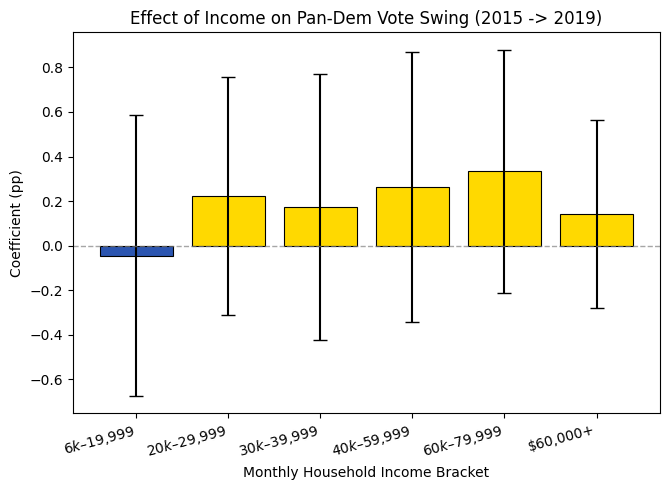

In [328]:
income_vars = [
    "p_I6000-9999","p_I10000-19999","p_I20000-29999",
    "p_I30000-39999","p_I40000-59999","p_I>60000"
]
df_inc = coef_se(res, income_vars)
# optional: relabel nicer tick text
nice = {
    "p_I6000-9999":"$6k–$19,999","p_I10000-19999":"$20k–$29,999",
    "p_I20000-29999":"$30k–$39,999","p_I30000-39999":"$40k–$59,999",
    "p_I40000-59999":"$60k–$79,999","p_I>60000":"$60,000+"
}
df_inc["var"] = df_inc["var"].map(nice).fillna(df_inc["var"])

plot_group(
    df_inc,
    title="Effect of Income on Pan-Dem Vote Swing (2015 -> 2019)",
    xlabel="Monthly Household Income Bracket",
    outfile="fig_income_swing.png",
    y0=0.0  # difference from baseline implied by other included shares
)

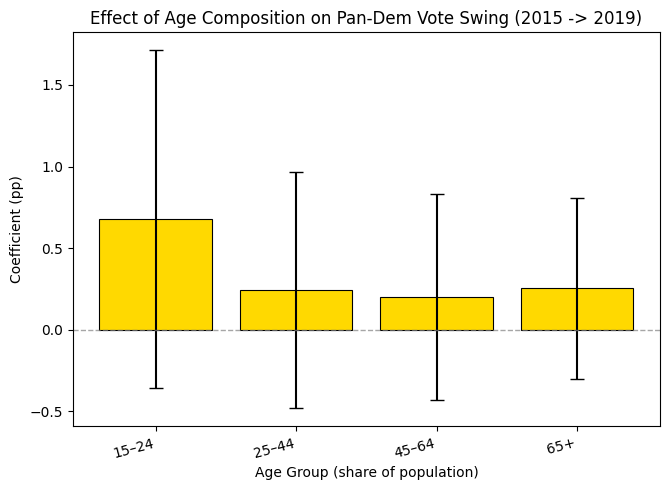

In [329]:
age_vars = ["p_15-24","p_25-44","p_45-64","p_>65"]  # if you dropped one in X, omit it here too
df_age = coef_se(res, age_vars)
nice_age = {"p_15-24":"15–24","p_25-44":"25–44","p_45-64":"45–64","p_>65":"65+"}
df_age["var"] = df_age["var"].map(nice_age)
plot_group(
    df_age,
    title="Effect of Age Composition on Pan-Dem Vote Swing (2015 -> 2019)",
    xlabel="Age Group (share of population)",
    outfile="fig_age_swing.png",
    y0=0.0
)

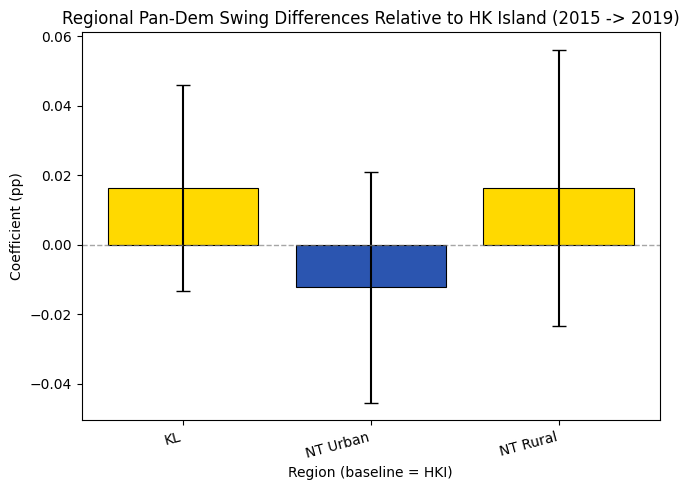

In [330]:
region_vars = ["KL","NT Urban","NT Rural"]  # ensure these match your dummy names
df_reg = coef_se(res, region_vars)
plot_group(
    df_reg,
    title="Regional Pan-Dem Swing Differences Relative to HK Island (2015 -> 2019)",
    xlabel="Region (baseline = HKI)",
    outfile="fig_region_swing.png",
    y0=0.0
)

In [331]:
model = sm.WLS(y2019, X, weights=w)
res = model.fit(cov_type='HC1')
print(res.summary())

                            WLS Regression Results                            
Dep. Variable:         2019_dem_votes   R-squared:                       0.201
Model:                            WLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.895
Date:                Tue, 04 Nov 2025   Prob (F-statistic):           3.43e-11
Time:                        15:39:23   Log-Likelihood:                 622.48
No. Observations:                 452   AIC:                            -1213.
Df Residuals:                     436   BIC:                            -1147.
Df Model:                          15                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5419      0.007     75.

In [332]:
print(res.f_test("p_15-24 = 0, p_25-44 = 0, p_45-64 = 0, p_>65 = 0"))
print(res.f_test("p_I6000-9999 = 0, p_I10000-19999 = 0, p_I20000-29999 = 0, p_I30000-39999 = 0, p_I40000-59999 = 0, p_I>60000 = 0"))
print(res.f_test("KL = 0, NT Urban = 0, NT Rural = 0"))

<F test: F=4.822071674731768, p=0.0008160459581952802, df_denom=436, df_num=4>
<F test: F=8.324780995539843, p=1.4846669350493483e-08, df_denom=436, df_num=6>
<F test: F=5.8827506518251935, p=0.0006072684766126757, df_denom=436, df_num=3>


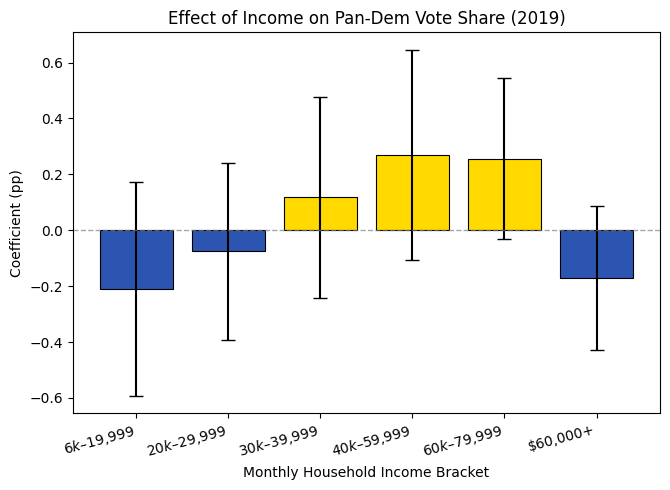

In [333]:
income_vars = [
    "p_I6000-9999","p_I10000-19999","p_I20000-29999",
    "p_I30000-39999","p_I40000-59999","p_I>60000"
]
df_inc = coef_se(res, income_vars)
# optional: relabel nicer tick text
nice = {
    "p_I6000-9999":"$6k–$19,999","p_I10000-19999":"$20k–$29,999",
    "p_I20000-29999":"$30k–$39,999","p_I30000-39999":"$40k–$59,999",
    "p_I40000-59999":"$60k–$79,999","p_I>60000":"$60,000+"
}
df_inc["var"] = df_inc["var"].map(nice).fillna(df_inc["var"])

plot_group(
    df_inc,
    title="Effect of Income on Pan-Dem Vote Share (2019)",
    xlabel="Monthly Household Income Bracket",
    outfile="fig_income_2019.png",
    y0=0.0  # difference from baseline implied by other included shares
)

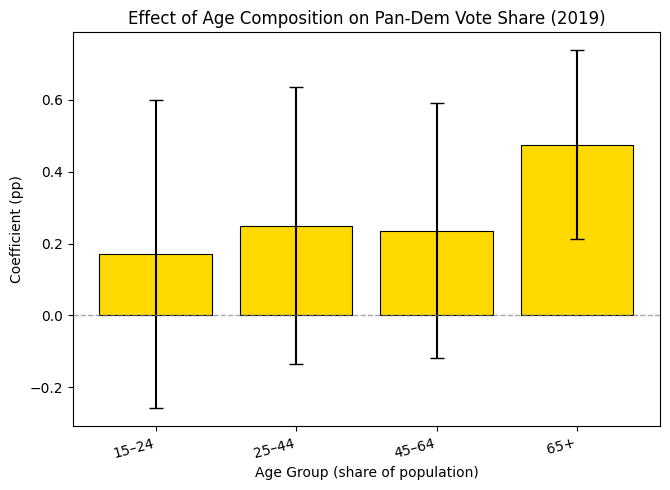

In [334]:
age_vars = ["p_15-24","p_25-44","p_45-64","p_>65"]  # if you dropped one in X, omit it here too
df_age = coef_se(res, age_vars)
nice_age = {"p_15-24":"15–24","p_25-44":"25–44","p_45-64":"45–64","p_>65":"65+"}
df_age["var"] = df_age["var"].map(nice_age)
plot_group(
    df_age,
    title="Effect of Age Composition on Pan-Dem Vote Share (2019)",
    xlabel="Age Group (share of population)",
    outfile="fig_age_2019.png",
    y0=0.0
)

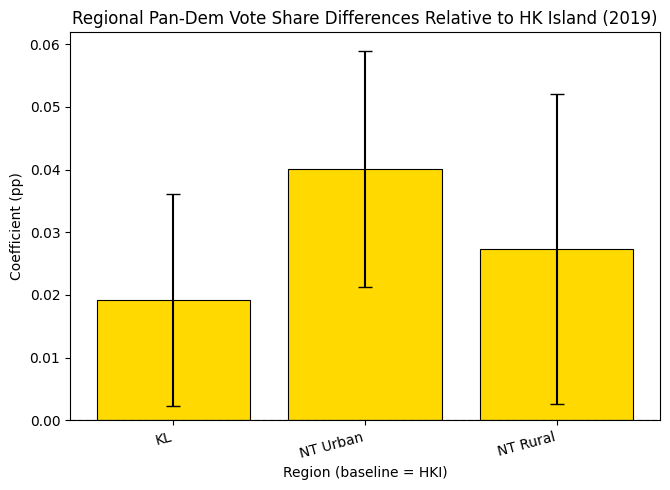

In [335]:
region_vars = ["KL","NT Urban","NT Rural"]  # ensure these match your dummy names
df_reg = coef_se(res, region_vars)
plot_group(
    df_reg,
    title="Regional Pan-Dem Vote Share Differences Relative to HK Island (2019)",
    xlabel="Region (baseline = HKI)",
    outfile="fig_region_2019.png",
    y0=0.0
)